<a href="https://colab.research.google.com/github/HaveFaith07/HaveFaith-Project/blob/Machine-Learning/Ethical_Uses_Of_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Final Assessment Ethical Issues of AI(WS0923)

Name: Mitesh Patole

Student Number : GH1022321

The data which i have used in this assessment is imported from kaggle

URL: https://www.kaggle.com/datasets/mohammadbolandraftar/credit-card-defaults-in-taiwan-ml-fairness

Github:https://github.com/HaveFaith07/HaveFaith-Project/blob/main/Ethical_Uses_Of_AI.ipynb

Inroduction:


The main goal here is to understand the details of fairness of AI and narrow down the potential limitations, Many AI models used in this context are not biased or serve unequal treatment based on factors such as the race, sex or the economic status of the individual.


Data Description

The dataset which i have used comes from kaggle, i have provided the link for the same, As fairness in the data plays a very cruical role, we need to also figure out the biasness in the same, as our data vulnerable features such as SEX, marriage, bill amount and interest, we need to check whether this feature have a huge impact in the result or not, which could lead to discriminatory outcomes in the further predictions.

Importance of Fairness

Opportunity should be equally allocated, Hence fairness plays a crucial role in machine learning ethics, As sometimes data is not completely reliable, we need to make sure the outcome for the same should be fair as it may affect the insights extracted from the data, we also nee to make sure the financial system is fair to every individual as automations is what future is about, AI here has made a huge contribution and has eased up huge number of business processes.

Approach and Justification

In such scenarios, we need to follow an approach which would not stand as a disadvantage to either of the groups,we need to follow an approach which would not result into negative sidelines while post processing, training and testing.We have used exponential gradient reduction method also i have tried implementing disparate mistreatment

Benefits and consequences:

This is more inclined towards fairness hence the conclusions wouldnt be completely predictive/ assumptous.
Machine learning also has its own limitations such as insufficient fairness, missing values etc which could result into application of asssumptous values yet relevant.

Insight and Visualization:
We have made multiple visualizations which showcase the posibile disparity in the sex , we have found the count of one sex is exceptionally higher compared to the other, which could result in unfair insights, hence we have applied a strong algorith, for the same " exponential gradient reduction"as it is sufficient to capture complex relationship in the data.


Please find the rest in the end of the report.

In [ ]:
!pip install fairlearn

Imported Package

In [ ]:
!pip install xlrd

Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import EqualizedOdds
from sklearn.model_selection import train_test_split
import warnings

warnings.simplefilter("ignore")

rand_seed = 1234
np.random.seed(rand_seed)

Loading the Dataset


In [ ]:
dataset = pd.read_csv("unfair_credit_loan_dataset.csv")

dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,Interest
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,689,0,0,0,0,1,2.942870
1,120000,2,2,2,26,-1,2,0,0,0,...,3455,3261,0,1000,1000,1000,0,2000,1,-0.381951
2,90000,2,2,2,34,0,0,0,0,0,...,14948,15549,1518,1500,1000,1000,1000,5000,0,2.865414
3,50000,2,2,1,37,0,0,0,0,0,...,28959,29547,2000,2019,1200,1100,1069,1000,0,-0.625304
4,50000,1,2,1,57,-1,0,-1,0,0,...,19146,19131,2000,36681,10000,9000,689,679,0,-0.720589


In [ ]:
dataset.shape

(30000, 25)

In [ ]:
categorical_features = ["SEX", "EDUCATION", "MARRIAGE"]

for col_name in categorical_features:
    dataset[col_name] = dataset[col_name].astype("category")

Y = dataset.loc[:, "default"]
A = dataset.loc[:, "SEX"]

X = pd.get_dummies(dataset.drop(columns=["default", "SEX"]))

A_str = A.map({1: "male", 2: "female"})

Visualization is as following

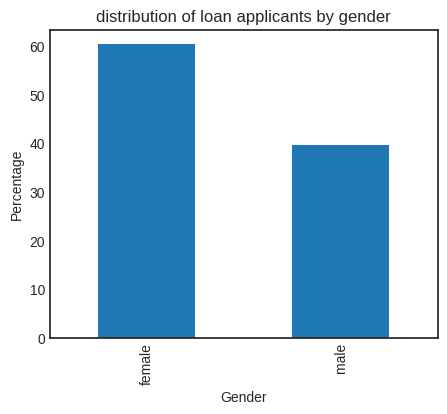

In [ ]:
(A_str.value_counts(normalize=True)*100).round(2).plot(kind='bar', figsize=(5, 4))
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.title('distribution of loan applicants by gender')
plt.show()

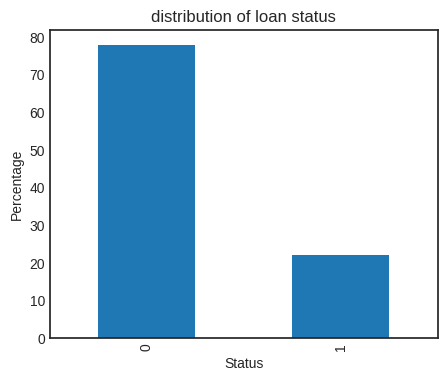

In [ ]:
(Y.value_counts(normalize=True)*100).round(2).plot(kind='bar', figsize=(5, 4))
plt.xlabel('Status')
plt.ylabel('Percentage')
plt.title('distribution of loan status')
plt.show()

In [ ]:
X.loc[:, "Interest"] = np.random.normal(loc=2 * Y, scale=A)

In [ ]:
merged_dataset = pd.concat([dataset, X["Interest"]], axis=1)

In [ ]:
merged_dataset['default'] = merged_dataset['default'].astype(str)
print(merged_dataset['default'].unique())



['1' '0']


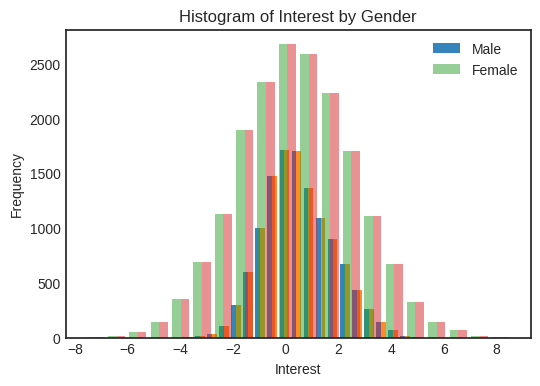

In [ ]:
male_interest = merged_dataset[merged_dataset['SEX'] == 1]['Interest']
female_interest = merged_dataset[merged_dataset['SEX'] == 2]['Interest']

plt.figure(figsize=(6,4))
plt.hist(male_interest, bins=20, alpha=0.9, label='Male')
plt.hist(female_interest, bins=20, alpha=0.5, label='Female')

plt.xlabel('Interest')
plt.ylabel('Frequency')
plt.title('Histogram of Interest by Gender')
plt.legend()

plt.show()

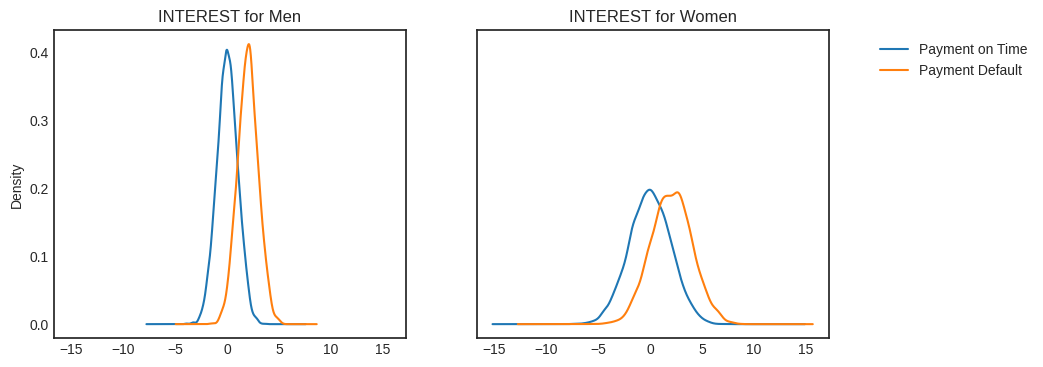

In [ ]:
fig, (ax_1, ax_2) = plt.subplots(
    ncols=2, figsize=(10, 4), sharex=True, sharey=True
)
X["Interest"][(A == 1) & (Y == 0)].plot(
    kind="kde", label="Payment on Time", ax=ax_1, title="INTEREST for Men"
)
X["Interest"][(A == 1) & (Y == 1)].plot(
    kind="kde", label="Payment Default", ax=ax_1
)
X["Interest"][(A == 2) & (Y == 0)].plot(
    kind="kde",
    label="Payment on Time",
    ax=ax_2,
    legend=True,
    title="INTEREST for Women",
)
X["Interest"][(A == 2) & (Y == 1)].plot(
    kind="kde", label="Payment Default", ax=ax_2, legend=True
).legend(bbox_to_anchor=(1.6, 1))

plt.show()

In [ ]:
def resample_training_data(X_train, Y_train, A_train):

    negative_ids = Y_train[Y_train == 0].index
    positive_ids = Y_train[Y_train == 1].index
    balanced_ids = positive_ids.union(
        np.random.choice(a=negative_ids, size=len(positive_ids))
    )

    X_train = X_train.loc[balanced_ids, :]
    Y_train = Y_train.loc[balanced_ids]
    A_train = A_train.loc[balanced_ids]
    return X_train, Y_train, A_train

X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X,
                                                                     Y,
                                                                     A_str,
                                                                     test_size=0.35,
                                                                     stratify=Y,
                                                                    )

X_train, y_train, A_train = resample_training_data(X_train, y_train, A_train)

In [ ]:
lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.03,
    "num_leaves": 10,
    "max_depth": 3,
    "random_state": rand_seed,
    "n_jobs": 1,
}

estimator = Pipeline(
    steps=[
        ("preprocessing", StandardScaler()),
        ("classifier", lgb.LGBMClassifier(**lgb_params)),
          ]
                    )

estimator.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 4313, number of negative: 4313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3523
[LightGBM] [Info] Number of data points in the train set: 8626, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc',
                                n_jobs=1, num_leaves=10, objective='binary',
                                random_state=1234))])

In [ ]:
Y_pred_proba = estimator.predict_proba(X_test)[:, 1]
Y_pred = estimator.predict(X_test)

roc_auc_score(y_test, Y_pred_proba)

0.8782234705862874

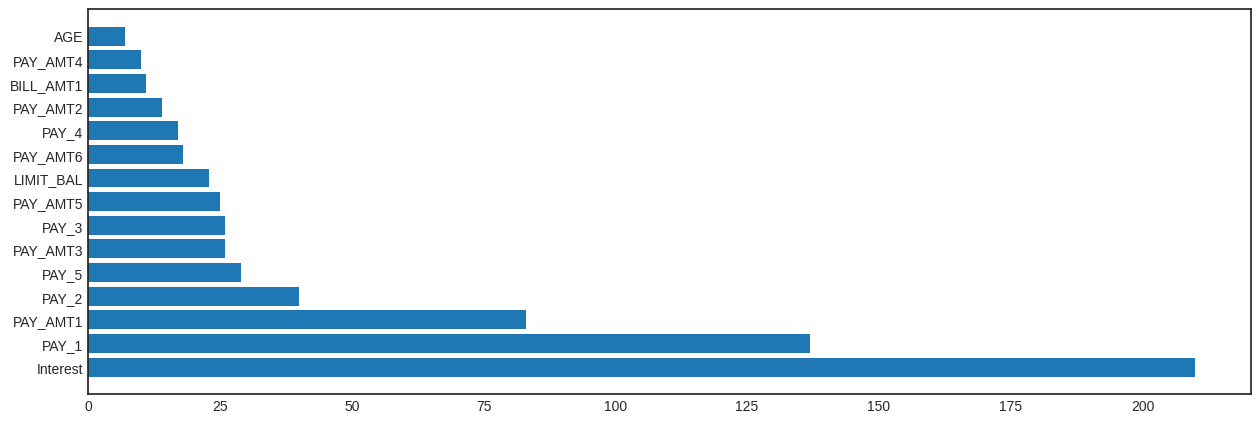

In [ ]:
important_features = pd.DataFrame(X_train.columns, estimator[1].feature_importances_).reset_index()
important_features.columns = ["importance", "feature_name"]
important_features = important_features.sort_values(by="importance", ascending=False)

plt.barh(important_features["feature_name"][:15], important_features["importance"][:15])
plt.show()

In [ ]:
def compute_error_metric(metric_value, sample_size):
    """Compute standard error of a given metric based on the assumption of
    normal distribution.

    Parameters:
    metric_value: Value of the metric
    sample_size: Number of data points associated with the metric

    Returns:
    The standard error of the metric
    """
    metric_value = metric_value / sample_size
    return (
        1.96
        * np.sqrt(metric_value * (1.0 - metric_value))
        / np.sqrt(sample_size)
    )


def false_positive_error(y_true, y_pred):
    """Compute the standard error for the false positive rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fp, tn + fp)


def false_negative_error(y_true, y_pred):
    """Compute the standard error for the false negative rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fn, fn + tp)


def balanced_accuracy_error(y_true, y_pred):
    """Compute the standard error for the balanced accuracy estimate."""
    fpr_error, fnr_error = false_positive_error(
        y_true, y_pred
    ), false_negative_error(y_true, y_pred)
    return np.sqrt(fnr_error**2 + fpr_error**2) / 2


fairness_metrics = {
    "count": count,
    "balanced_accuracy": balanced_accuracy_score,
    "balanced_acc_error": balanced_accuracy_error,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "false_positive_error": false_positive_error,
    "false_negative_rate": false_negative_rate,
    "false_negative_error": false_negative_error,
}

In [ ]:
metrics_to_report = ["selection_rate", "false_positive_rate", "false_negative_rate", "balanced_accuracy",]

In [ ]:
metricframe_unmitigated = MetricFrame(metrics=fairness_metrics,
                                      y_true=y_test,
                                      y_pred=Y_pred,
                                      sensitive_features=A_test,
                                     )

print("metricframe_unmitigated (fairness unaware):")
a = pd.DataFrame(metricframe_unmitigated.by_group[metrics_to_report])
b= pd.DataFrame(metricframe_unmitigated.overall[metrics_to_report], columns=["Overall"]).T
pd.concat([a,b])

metricframe_unmitigated (fairness unaware):


,selection_rate,false_positive_rate,false_negative_rate,balanced_accuracy
female,0.363981,0.255571,0.23573,0.754349
male,0.306475,0.132979,0.12423,0.871396
Overall,0.341143,0.207656,0.18898,0.801682


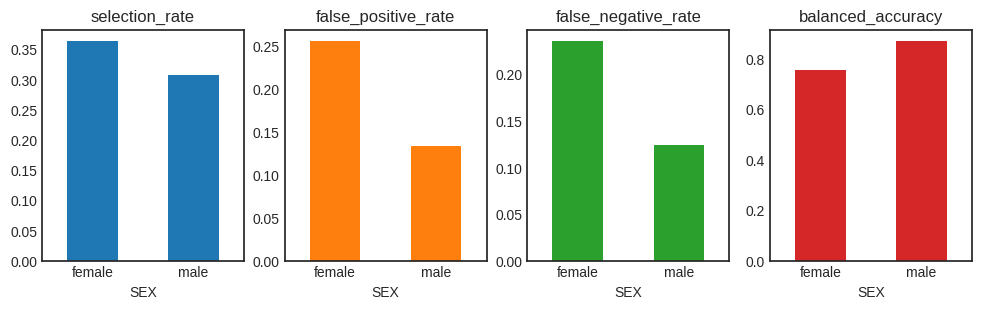

In [ ]:
metricframe_unmitigated.by_group[metrics_to_report].iloc[:,0:4].plot.bar(subplots=True,
                                                                         layout=[1, 4],
                                                                         figsize=[12, 3],
                                                                         legend=None,
                                                                         rot=0
                                                                        )
plt.show()

In [ ]:
balanced_accuracy_unmitigated = balanced_accuracy_score(y_test, Y_pred)
equalized_odds_unmitigated = equalized_odds_difference(
    y_test, Y_pred, sensitive_features=A_test
)

In [ ]:
postprocess_est = ThresholdOptimizer(
    estimator=estimator,
    constraints="equalized_odds",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method="predict_proba",
)

postprocess_est

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=Pipeline(steps=[('preprocessing',
                                              StandardScaler()),
                                             ('classifier',
                                              LGBMClassifier(learning_rate=0.03,
                                                             max_depth=3,
                                                             metric='auc',
                                                             n_jobs=1,
                                                             num_leaves=10,
                                                             objective='binary',
                                                             random_state=1234))]),
                   objective='balanced_accuracy_score',
                   predict_method='predict_proba', prefit=True)

In [ ]:
postprocess_est.fit(X=X_train, y=y_train, sensitive_features=A_train)

postprocess_pred = postprocess_est.predict(X_test, sensitive_features=A_test)

postprocess_pred_proba = postprocess_est._pmf_predict(X_test, sensitive_features=A_test)




In [ ]:
bal_acc_postprocess = balanced_accuracy_score(y_test, postprocess_pred)

eq_odds_postprocess = equalized_odds_difference(y_test, postprocess_pred, sensitive_features=A_test)

metricframe_postprocess = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=postprocess_pred,
    sensitive_features=A_test,
)

In [ ]:
print("metricframe Threshold Optimizer:")
c = pd.DataFrame(metricframe_postprocess.by_group[metrics_to_report])
d= pd.DataFrame(metricframe_postprocess.overall[metrics_to_report], columns=["Overall"]).T
pd.concat([c,d])

metricframe Threshold Optimizer:


,selection_rate,false_positive_rate,false_negative_rate,balanced_accuracy
female,0.379463,0.271431,0.221646,0.753461
male,0.395923,0.268461,0.185832,0.772854
Overall,0.386000,0.270270,0.206629,0.761550


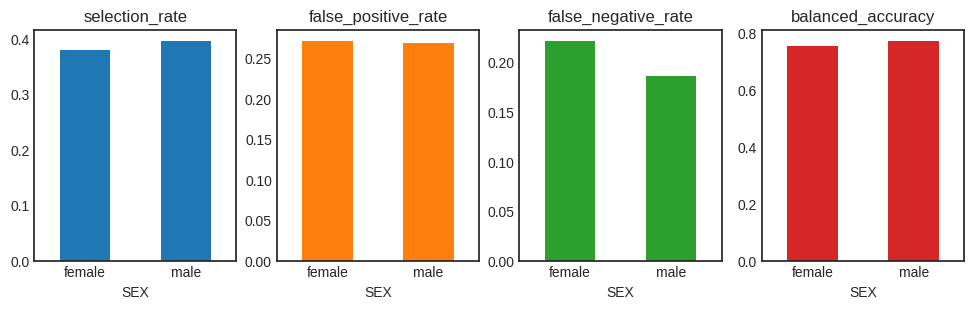

In [ ]:
metricframe_postprocess.by_group[metrics_to_report].iloc[:,0:4].plot.bar(
    subplots=True, layout=[1, 4], figsize=[12, 3], legend=None, rot=0
)
plt.show()

In [ ]:
def get_expgrad_models_per_epsilon(
    estimator, epsilon, X_train, y_train, A_train
):

    exp_grad_est = ExponentiatedGradient(
        estimator=estimator,
        sample_weight_name='classifier__sample_weight',
        constraints=EqualizedOdds(difference_bound=epsilon),
    )

    exp_grad_est.fit(X_train, y_train, sensitive_features=A_train)
    predictors = exp_grad_est.predictors_
    return predictors

In [ ]:
epsilons = [0.01, 0.02]

all_models = {}

for eps in epsilons:
    all_models[eps] = get_expgrad_models_per_epsilon(
        estimator=estimator,
        epsilon=eps,
        X_train=X_train,
        y_train=y_train,
        A_train=A_train,
    )


In [ ]:
for epsilon, models in all_models.items():
    print(
        f"For epsilon {epsilon}, ExponentiatedGradient learned {len(models)} inner models"
    )

For epsilon 0.01, ExponentiatedGradient learned 17 inner models
For epsilon 0.02, ExponentiatedGradient learned 19 inner models


In [ ]:
def is_pareto_efficient(points):

    n, m = points.shape
    is_efficient = np.ones(n, dtype=bool)
    for i, c in enumerate(points):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(
                points[is_efficient] < c, axis=1
            )
            is_efficient[i] = True
    return is_efficient

In [ ]:
def filter_dominated_rows(points):

    pareto_mask = is_pareto_efficient(points.to_numpy())
    return pareto_mask, points.loc[pareto_mask, :]

In [ ]:
def aggregate_predictor_performances(
    predictors, metric, X_test, Y_test, A_test=None
):
    all_predictions = [predictor.predict(X_test) for predictor in predictors]
    if A_test is not None:
        return [
            metric(Y_test, Y_sweep, sensitive_features=A_test)
            for Y_sweep in all_predictions
        ]
    else:
        return [metric(Y_test, Y_sweep) for Y_sweep in all_predictions]


In [ ]:
def model_performance_sweep(models_dict, X_test, y_test, A_test):

    performances = []
    for (eps, models) in models_dict.items():
        eq_odds_difference = aggregate_predictor_performances(
            models, equalized_odds_difference, X_test, y_test, A_test
        )
        bal_acc_score = aggregate_predictor_performances(
            models, balanced_accuracy_score, X_test, y_test
        )
        for (i, score) in enumerate(eq_odds_difference):
            performances.append((eps, i, score, (1 - bal_acc_score[i])))
    performances_df = pd.DataFrame.from_records(
        performances,
        columns=["epsilon", "index", "equalized_odds", "balanced_error"],
    )
    return performances_df

In [ ]:
performance_df = model_performance_sweep(all_models, X_test, y_test, A_test)
performance_df

,epsilon,index,equalized_odds,balanced_error
0,0.01,0,0.122592,0.198318
1,0.01,1,0.120384,0.197860
2,0.01,2,0.366542,0.637947
3,0.01,3,0.117107,0.199406
4,0.01,4,0.367404,0.640109
5,0.01,5,0.222162,0.466605
6,0.01,6,0.106041,0.198932
7,0.01,7,0.185680,0.320563
8,0.01,8,0.098136,0.198655
9,0.01,9,0.028247,0.254847


In [ ]:
performance_subset = performance_df.loc[:, ["equalized_odds", "balanced_error"]]
mask, pareto_subset = filter_dominated_rows(performance_subset)

performance_df_masked = performance_df.loc[mask, :]

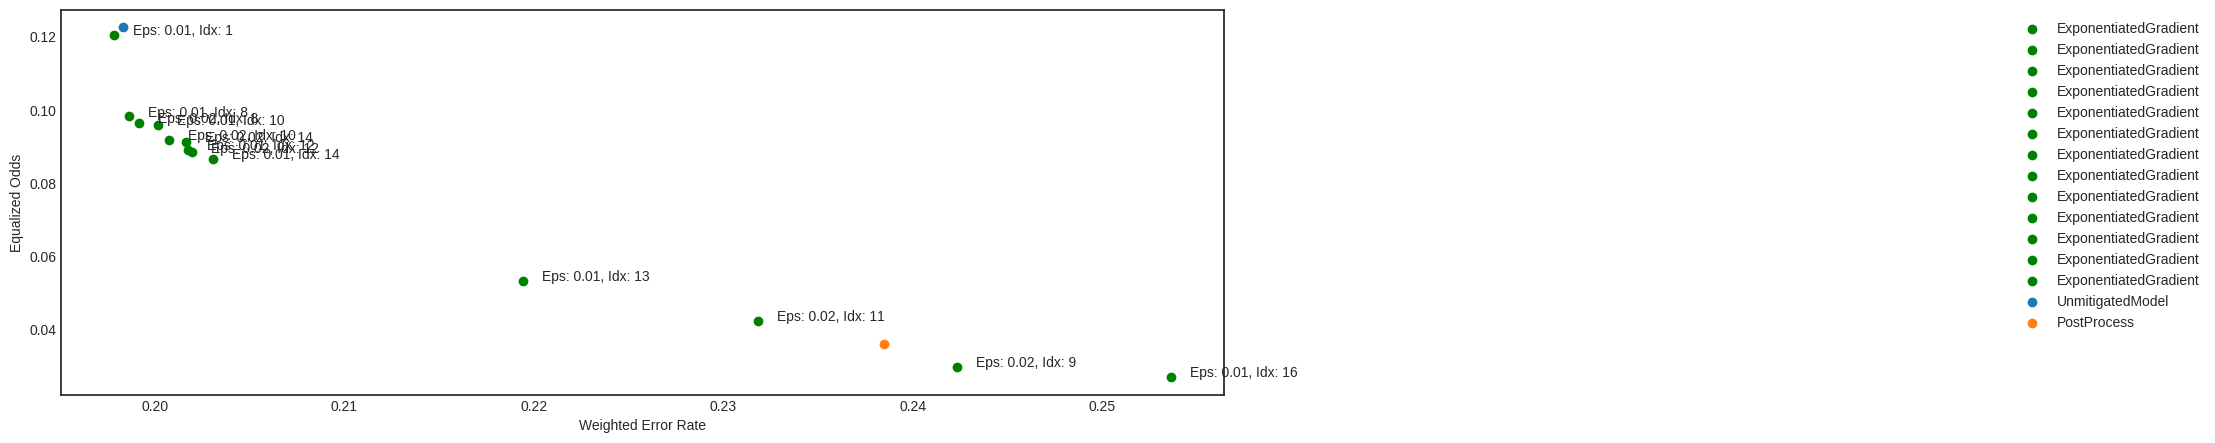

In [ ]:
for index, row in performance_df_masked.iterrows():
    bal_error, eq_odds_diff = row["balanced_error"], row["equalized_odds"]
    epsilon_, index_ = row["epsilon"], row["index"]
    plt.scatter(
        bal_error, eq_odds_diff, color="green", label="ExponentiatedGradient"
    )
    plt.text(
        bal_error + 0.001,
        eq_odds_diff + 0.0001,
        f"Eps: {epsilon_}, Idx: {int(index_)}",
        fontsize=10,
    )
plt.scatter(
    1.0 - balanced_accuracy_unmitigated,
    equalized_odds_unmitigated,
    label="UnmitigatedModel",
)
plt.scatter(
    1.0 - bal_acc_postprocess, eq_odds_postprocess, label="PostProcess"
)
plt.xlabel("Weighted Error Rate")
plt.ylabel("Equalized Odds")
plt.legend(bbox_to_anchor=(1.85, 1))
plt.show()

In [ ]:
def filter_models_by_unmitigiated_score(
    all_models,
    models_frames,
    unmitigated_score,
    performance_metric="balanced_error",
    fairness_metric="equalized_odds",
    threshold=0.01,
):


    models_filtered = models_frames.query(
        f"{performance_metric} <= {unmitigated_score + threshold}"
    )
    best_row = models_filtered.sort_values(by=[fairness_metric]).iloc[0]

    epsilon, index = best_row[["epsilon", "index"]]
    return {
        "model": all_models[epsilon][index],
        "epsilon": epsilon,
        "index": index,
    }


In [ ]:
best_model = filter_models_by_unmitigiated_score(
    all_models,
    models_frames=performance_df,
    unmitigated_score=(1.0 - balanced_accuracy_unmitigated),
    threshold=0.015,
)

print(
    f"Epsilon for best model: {best_model.get('epsilon')}, Index number: {best_model.get('index')}"
)
inprocess_model = best_model.get("model")

Epsilon for best model: 0.01, Index number: 14.0


In [ ]:
y_pred_inprocess = inprocess_model.predict(X_test)

bal_acc_inprocess = balanced_accuracy_score(y_test, y_pred_inprocess)
eq_odds_inprocess = equalized_odds_difference(
    y_test, y_pred_inprocess, sensitive_features=A_test
)


In [ ]:
metricframe_inprocess = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=y_pred_inprocess,
    sensitive_features=A_test,
)

Post processing followed by disparate mistreatment

In [ ]:
from sklearn.metrics import confusion_matrix



new_threshold = 0.6


Y_pred_thresholded_new = (Y_pred_proba > new_threshold).astype(int)


conf_matrix_new = confusion_matrix(y_test, Y_pred_thresholded_new)
tn_new, fp_new, fn_new, tp_new = conf_matrix_new.ravel()


fpr_new = fp_new / (fp_new + tn_new)
fnr_new = fn_new / (fn_new + tp_new)


postprocess_pred_male = postprocess_pred[A_test == 'male']
postprocess_pred_female = postprocess_pred[A_test == 'female']

fair_fpr_male = false_positive_rate(y_test[A_test == 'male'], postprocess_pred_male)
fair_fnr_male = false_negative_rate(y_test[A_test == 'male'], postprocess_pred_male)

fair_fpr_female = false_positive_rate(y_test[A_test == 'female'], postprocess_pred_female)
fair_fnr_female = false_negative_rate(y_test[A_test == 'female'], postprocess_pred_female)


print("Fair False Positive Rate (FPR) for Male Group:", fair_fpr_male)
print("Fair False Negative Rate (FNR) for Male Group:", fair_fnr_male)

print("Fair False Positive Rate (FPR) for Female Group:", fair_fpr_female)
print("Fair False Negative Rate (FNR) for Female Group:", fair_fnr_female)





Fair False Positive Rate (FPR) for Male Group: 0.26846057571964954
Fair False Negative Rate (FNR) for Male Group: 0.18583162217659138
Fair False Positive Rate (FPR) for Female Group: 0.27143143946998594
Fair False Negative Rate (FNR) for Female Group: 0.22164566345441067


In [ ]:
print("metricframe ExponentiatedGradient:")
e = pd.DataFrame(metricframe_inprocess.by_group[metrics_to_report])
f = pd.DataFrame(metricframe_inprocess.overall[metrics_to_report], columns=["Overall"]).T
pd.concat([c,d])

metricframe ExponentiatedGradient:


,selection_rate,false_positive_rate,false_negative_rate,balanced_accuracy
female,0.379463,0.271431,0.221646,0.753461
male,0.395923,0.268461,0.185832,0.772854
Overall,0.386000,0.270270,0.206629,0.761550


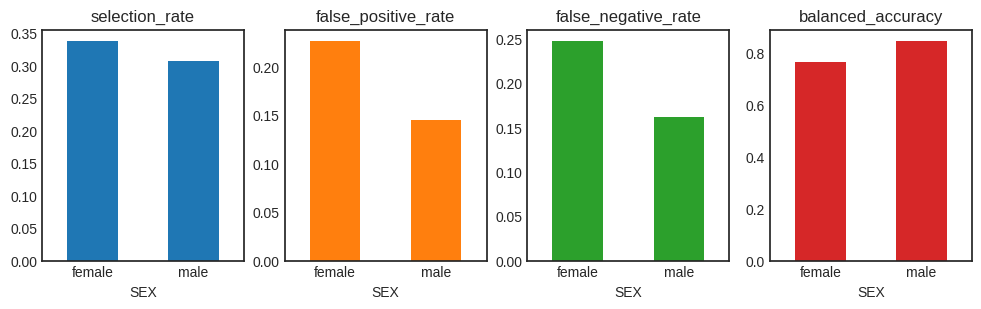

In [ ]:
metricframe_inprocess.by_group[metrics_to_report].iloc[:,0:4].plot.bar(
    subplots=True, layout=[1, 4], figsize=[12, 3], legend=None, rot=0
)
plt.show()

Total count

Gender Distribution:
SEX
Female    18112
Male      11888
Name: count, dtype: int64


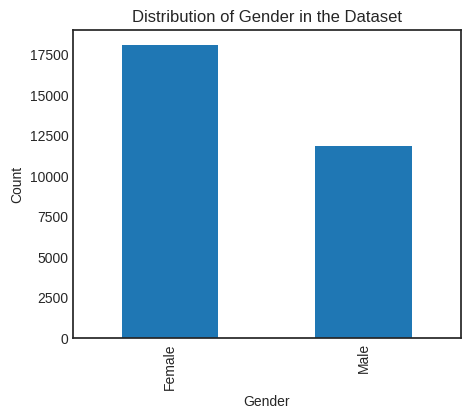

In [ ]:

gender_counts = dataset['SEX'].map({1: 'Male', 2: 'Female'}).value_counts()
print("Gender Distribution:")
print(gender_counts)

gender_counts.plot(kind='bar', figsize=(5, 4))
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Gender in the Dataset')
plt.show()


In [ ]:
unmitigated_df = pd.DataFrame(metricframe_unmitigated.by_group[metrics_to_report].unstack())
unmitigated_df.columns = ["unmitigated_df"]
unmitigated_df = unmitigated_df.T

postprocess_df = pd.DataFrame(metricframe_postprocess.by_group[metrics_to_report].unstack())
postprocess_df.columns = ["postprocess_df"]
postprocess_df = postprocess_df.T

inprocess_df = pd.DataFrame(metricframe_inprocess.by_group[metrics_to_report].unstack())
inprocess_df.columns = ["inprocess_df"]
inprocess_df = inprocess_df.T

compare_results = pd.concat([unmitigated_df, postprocess_df, inprocess_df], axis=0)
round(compare_results *100, 2)

selection_rate        false_positive_rate         \
SEX                    female   male              female   male   
unmitigated_df          36.40  30.65               25.56  13.30   
postprocess_df          37.95  39.59               27.14  26.85   
inprocess_df            33.87  30.72               22.67  14.52   

               false_negative_rate        balanced_accuracy         
SEX                         female   male            female   male  
unmitigated_df               23.57  12.42             75.43  87.14  
postprocess_df               22.16  18.58             75.35  77.29  
inprocess_df                 24.76  16.12             76.29  84.68

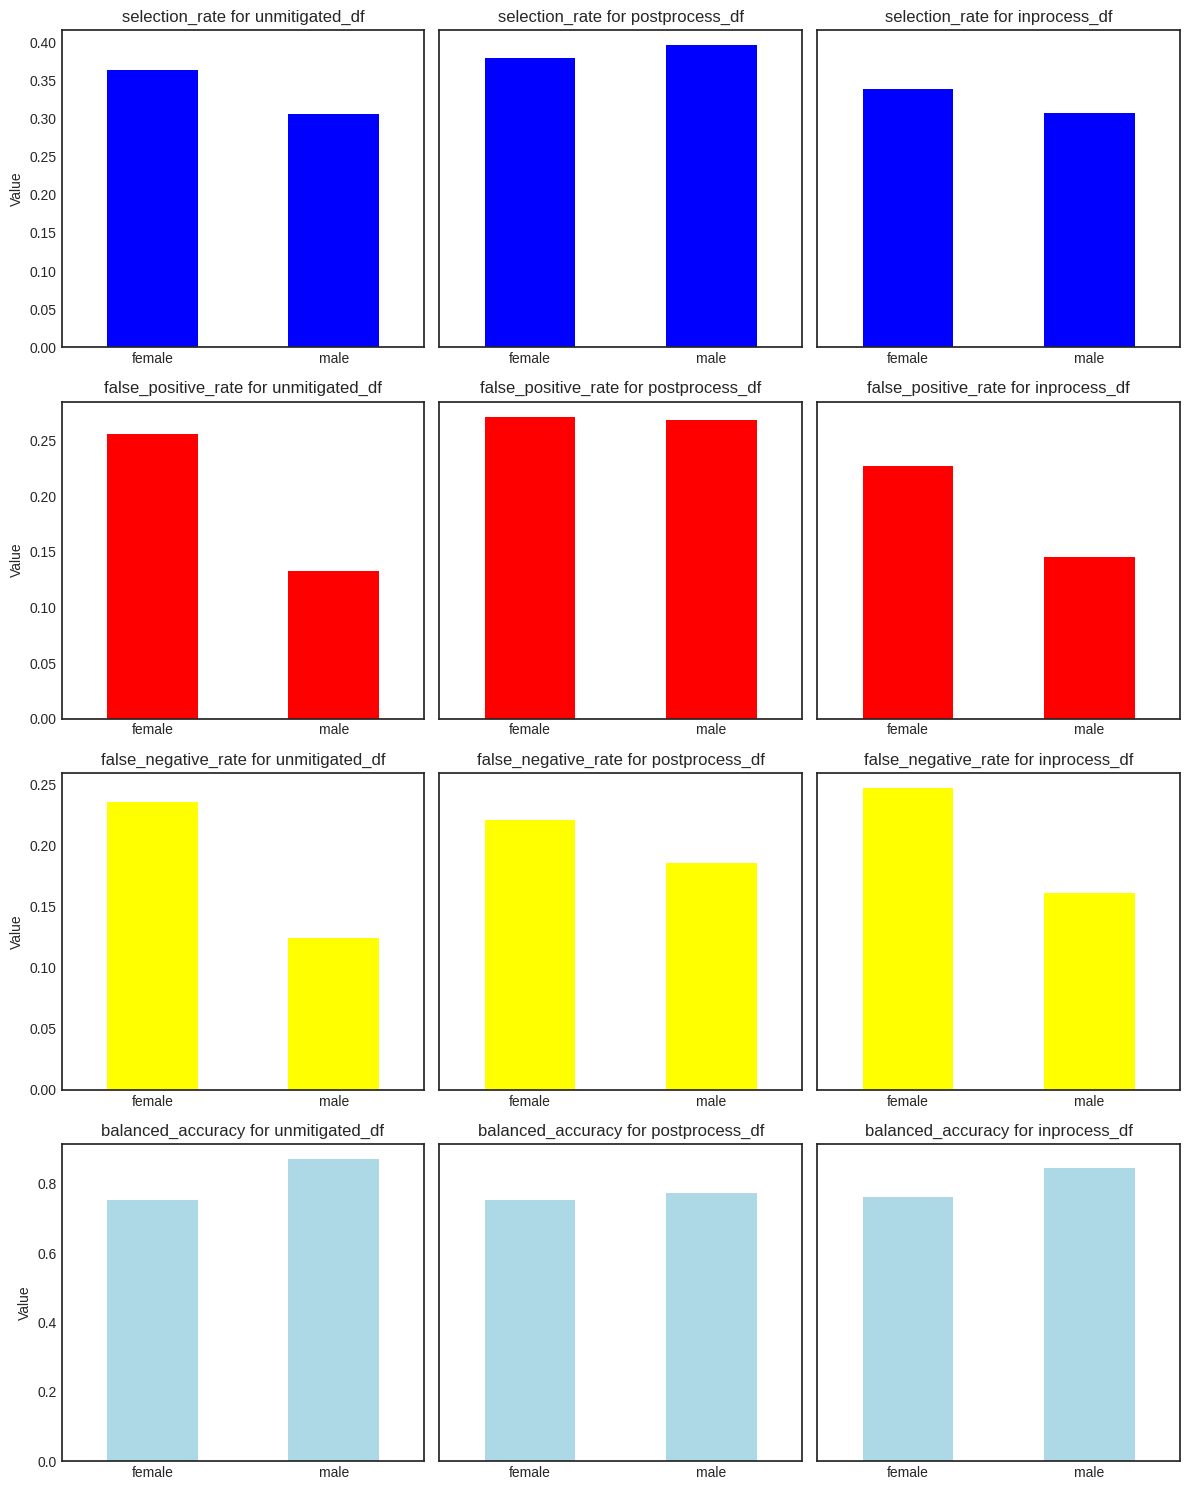

In [ ]:
column_colors = ['blue', 'red', 'yellow', 'lightblue']

fig, axs = plt.subplots(4, 3, figsize=(12, 15), sharey='row')

for i, col in enumerate(['selection_rate', 'false_positive_rate', 'false_negative_rate', 'balanced_accuracy']):

    color = column_colors[i]

    for j, row in enumerate(['unmitigated_df', 'postprocess_df', 'inprocess_df']):
        subset = compare_results.xs(col, axis=1, level=0).loc[row]
        subset.plot(kind='bar', ax=axs[i, j], rot=0, color=[color, color])

        axs[i, j].set_title(f'{col} for {row}')
        axs[i, j].set_xlabel('')
        axs[i, j].set_ylabel('Value')

plt.tight_layout()

plt.show()

Conclusion:
After careful observation, we have concluded that we have achieved a good amount of fairness, not the best, as the dataset had huge amount of values for one of the sex's, but surely we can make improvements with different approach. We somehow subsequently managed to get the FPR and FNR for both Sex's to a fair point wherein we can extract fair insights.

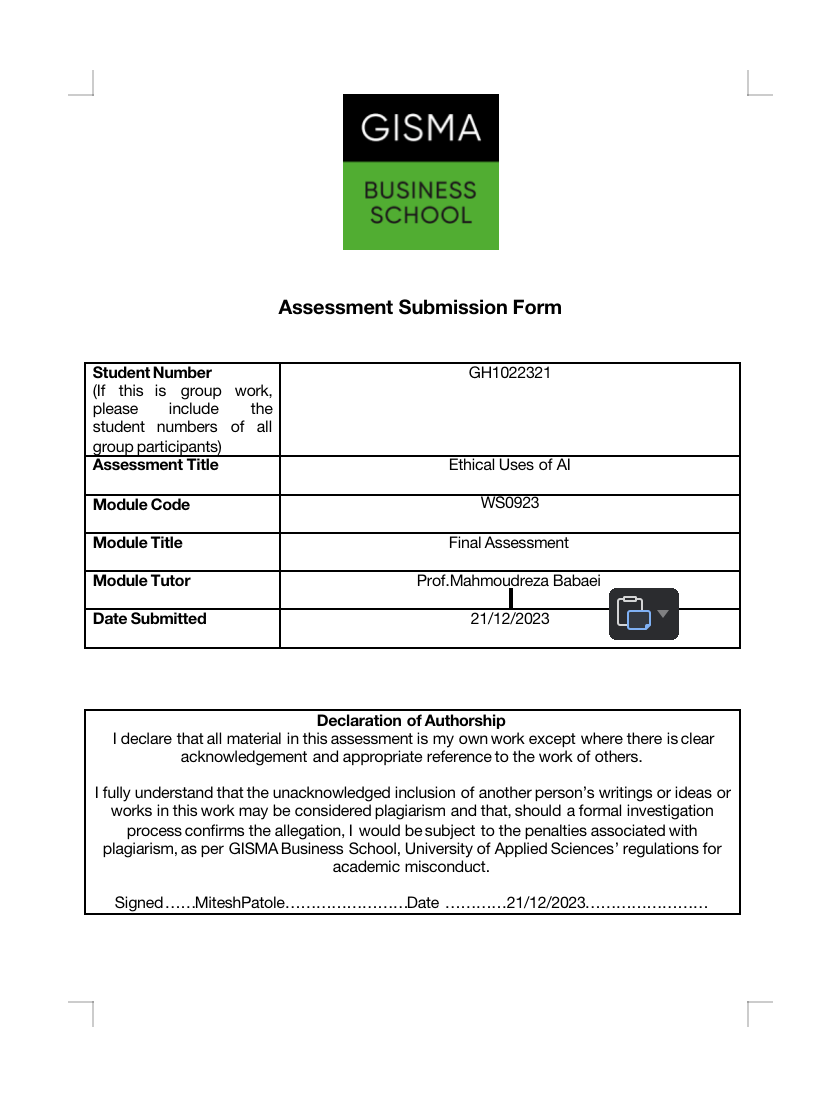

In [ ]:
!jupyter nbconvert --to html Ethical_Uses_Of_AI.ipynb

[NbConvertApp] Converting notebook Ethical_Uses_Of_AI.ipynb to html
[NbConvertApp] Writing 1385962 bytes to Ethical_Uses_Of_AI.html
